# Fine-Tunen von BERT für Named Entity Recognition (Musterlösung)

von Andreas Sünder & Benjamin Kissinger

Das folgende Notebook stellt ein Tutorial dar, wie man das Sprachmodell `bert-base-cased` (oder auch kurz "BERT") für Named Entity Recognition (NER) feintunen kann.

Hinweise vorab:
- Das Training von BERT mit dem hier vorgestellten Code braucht etwa 1.4 GB (oder mehr) RAM/vRAM. Eine GPU von NVIDIA ist empfehlenswert, um das Training zu beschleunigen.
- Alternativ zu `bert-base-cased` kann auch `distilbert/distilbert-base-cased` verwendet werden, welches 40% kleiner ist (jedoch kann es sein, dass es nicht so gut performt).

Bevor wir anfangen, ist es wichtig, dass wir alle benötigten Python-Libraries installieren:

```bash
pip install torch --index-url https://download.pytorch.org/whl/cpu  # Wenn eine CPU verwendet wird und keine NVIDIA-GPU vorhanden ist
pip install torch  # Wenn eine NVIDIA-GPU vorhanden ist
pip install datasets transformers seqeval numpy
```

Dann können wir beginnen! Zuerst laden wir den `conllpp`-Datensatz (Link: https://huggingface.co/datasets/conllpp) aus dem HuggingFace-Repository. Dies geschieht über die Methode `load_dataset()`, wobei der Name des Datensatzes dem Namen des Datensatzes im HuggingFace-Repository entspricht.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("conllpp")

Die `datasets`-Library ist so gemacht, dass nur einmal die Daten in ein Cache-Verzeichnis (üblicherweise ` ~/.cache/huggingface/datasets`) heruntergeladen werden und dann von dort aus verwendet werden. Das ist sehr praktisch, da wir so nicht jedes Mal, die Daten erneut herunterladen müssen. Schauen wir uns den Datensatz auf der HuggingFace-Webseite genauer an:

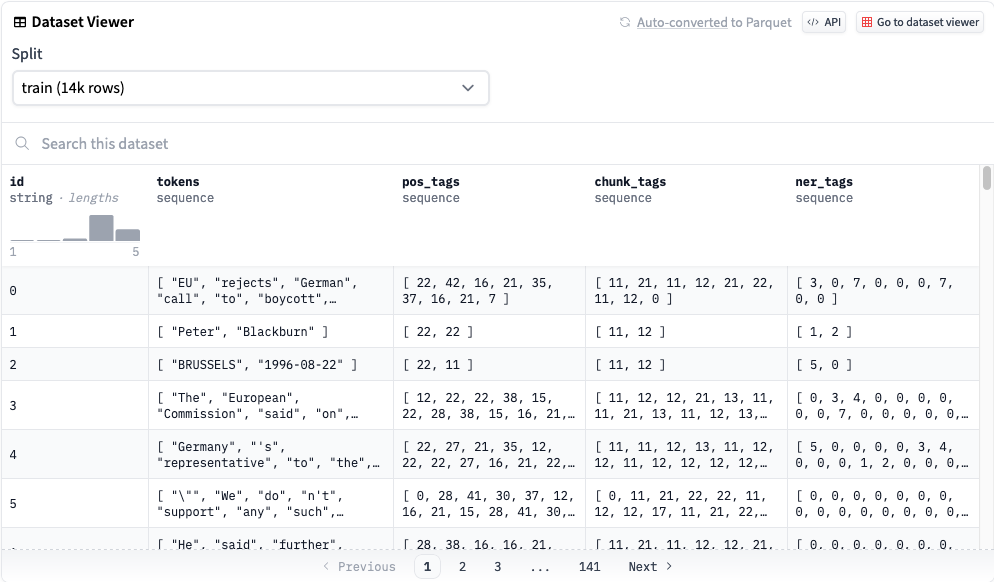

Wir sehen hier mehrere Spalten. Die Spalte `tokens` speichert die einzelnen Sätze, welche schon im Vorhinein getrennt und mit den entsprechenden NER-Tags versehen worden sind. Diese finden sich in der Spalte `ner_tags`. Uns fällt auf, dass die Arrays aus `ner_tags` und `tokens` die gleiche Länge haben, da *jedem* Token ein NER-Tag manuell zugewiesen worden ist. Ist einem Wort kein spezielles NER-Tag zugewiesen worden, so bekommt es das Tag `0`. Alle anderen Tags sind natürliche Zahlen. Da nicht direkt ersichtlich ist, welche möglichen Tags es gibt, können wir uns diese hier im Code anschauen:

In [2]:
tags = dataset["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None)


Jetzt ist das ganze etwa klarer. Die Zahlen, die in der Spalte `ner_tags` eingetragen sind, entsprechenden den Indezes der obigen Liste (`names`). Diese NER-Tags sind nach dem BIO-Format getaggt. Wir werden später noch sehen, warum das so ist. Was wir auch sehen, ist, dass in diesem Datensatz offenbar "nur" nach Personen, Organisationen, Orten und MISC (miscellaneous) getaggt ist (andere Datensätze haben vielleicht mehr und andere Tags). Das ist für uns aber in Ordnung.

Was uns auch auffällt, ist, dass der Datensatz offenbar in Subsets aufgeteilt ist:

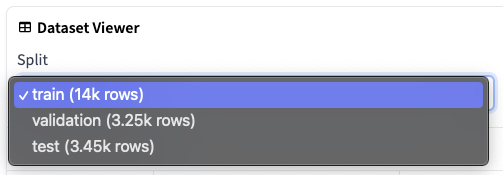

Wir sehen, dass es hier drei verschiedene Subsets gibt: `train`, `validation` und `test`. Wir die Namen schon verraten, werden wir später mit dem Trainingsdatensatz das Modell *trainieren* und mit dem Validierungsdatensatz das Modell *evaluieren*. Schließlich wollen wir unser Modell auch auf neue Daten testen, die es noch nie vorher gesehen hat. Das gibt uns ein Gefühl dafür, wie gut unser Modell auf neue Daten reagiert (und gibt uns gleichzeitig auch Auskunft darüber, ob wir etwas beim Training falsch gemacht haben).

Nun zurück zum Code. Der Grund, warum wir nicht einfach nach `PER` taggen können, sondern immer zwei Tags (jeweils mit `B-` und `I-`-Prefix) brauchen, liegt an der sogenannten *Tokenization*. Im Hintergrund können Sprachmodelle (dazu zählen BERT, Mistral, GPT etc.) nicht direkt ganze Sätze verarbeiten - diese müssen in kleinere Teile zerlegt werden. Eine Möglichkeit wäre (so wie wir es in der Spalte `tokens` gesehen haben), die Sätze in einzelne Wörter zu zerlegen. In der Praxis wird das aber nicht gemacht, da es zu viele Wörter gibt und die Modelle dann zu groß werden. Stattdessen werden die Sätze in noch kleinere Teile zerlegt, den sogenannten *Tokens*. Diese bestehen meistens aus 3-4 Zeichen. Um uns das besser vorstellen zu können, können wir uns den Tokenizer von GPT-4 anschauen (Link: https://platform.openai.com/tokenizer):

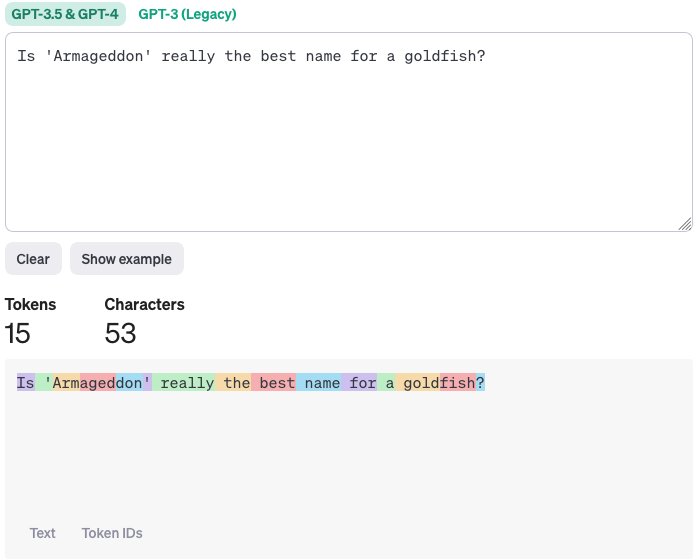

Hier wurde unser Beispielsatz in 15 Tokens zerlegt, welche farbig markiert sind. Jetzt sehen wir auch das Problem: manche Wörter sind so lang, dass sie in zwei oder mehr Teile vom Tokenizer aufgeteilt werden müssen. Wird ein Wort in zwei oder mehr Teile aufgeteilt, so wird das erste Token mit `B-` getaggt und alle weiteren mit `I-`. Probieren wir das mal mit dem Tokenizer von BERT aus:

In [1]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Hier verwenden wir die `transformers`-Library von HuggingFace, um wieder aus deren Repository den Tokenizer für unser BERT-Modell (Link: https://huggingface.co/bert-base-cased) zu laden. Hier entspricht der erste Parameter der `from_pretrained()`-Methode dem Namen des Modells. Wichtig ist noch zu verstehen, dass *jedes* Sprachmodell einen Tokenizer braucht, ohne diesem kann es nicht arbeiten. Des Weiteren muss es der *richtige* Tokenizer sein, da sonst die Tokenisierung nicht korrekt funktioniert.

Möchten wir einen Text tokenisieren, geht das sehr einfach mit der `tokenize()`-Methode:

In [9]:
tokenizer.tokenize("Is 'Armageddon' really the best name for a goldfish?")

['Is',
 "'",
 'Arm',
 '##aged',
 '##don',
 "'",
 'really',
 'the',
 'best',
 'name',
 'for',
 'a',
 'gold',
 '##fish',
 '?']

Hier sehen wir denselben Satz wie oben, und auch BERT hat ihn in 15 Tokens zerlegt (das war jetzt reiner Zufall). Wir sehen auch, dass manche Wörter ein `##`-Prefix besitzen. Das bedeutet, dass das Token ein Teil eines längeren Wortes ist, falls wir den Tokenizer wieder verwenden wollen, um den die Wörter mit `decode` wieder zusammenzusetzen:

In [10]:
tokenizer.decode(tokenizer.encode("Is 'Armageddon' really the best name for a goldfish?"))

"[CLS] Is'Armageddon'really the best name for a goldfish? [SEP]"

Wir ignorieren hier einmal `[CLS]` und `[SEP]` und sehen, dass unser Satz wieder korrekt zusammengesetzt worden ist.

Im Hintergrund arbeitet unser Modell aber auch nicht mit den Tokens als Strings, sondern mit ihren *IDs*:

In [16]:
tokenized_input = tokenizer("Is 'Armageddon' really the best name for a goldfish?")
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
word_ids = tokenized_input.word_ids()

import pandas as pd
pd.DataFrame([tokens, tokenized_input["input_ids"], word_ids], index=["Tokens", "Input IDs", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,[CLS],Is,',Arm,##aged,##don,',really,the,best,name,for,a,gold,##fish,?,[SEP]
Input IDs,101,2181,112,24446,15841,3842,112,1541,1103,1436,1271,1111,170,2284,6529,136,102
Word IDs,None,0,1,2,2,2,3,4,5,6,7,8,9,10,10,11,None


Hier sehen wir alles schön bei einander. Die erste Zeile repräsentiert die Tokens als getrennte Strings. Die zweite Zeile sind die Token-IDs (oder auch *Input-IDs* genannt). Letztendlich haben wir dann ein Array von Token-IDs, welches wir unserem Modell geben können. In der letzten Zeile sehen wir noch die Word-IDs, welche uns sagen, zu welchem Wort ein bestimmtes Token gehört (zum 0., zum 1. etc.).

Mit diesem Wissen können wir nun weitergehen und unser Modell laden. Dies geschieht wieder über die `transformers`-Library. Beim Laden des Modells müssen wir die Anzahl der möglichen NER-Tags sowie eine Zuordnung von den Indezes zu den NER-Tags und umgekehrt angeben (damit weiß das Modell über die Tags Bescheid):

In [4]:
from transformers import AutoModelForTokenClassification

index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2index,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hier bekommen wir auch gleich eine Warnung, dass manche Parameter des Modells noch nicht trainiert worden sind und auf zufällige Werte gesetzt worden sind. Das ist für uns in Ordnung.

Nun müssen wir unsere Daten so bearbeiten, wie wir es vorher mit dem Tokenizer gemacht haben. Dazu wenden wir den Tokenizer auf den gesamten Datensatz (inkl. aller drei Subsets) an. Dies geschieht mit der `map()`-Methode von `datasets`, der wir eine Funktion mitgeben, welche auf jede Zeile des Datensatzes angewendet wird. Unsere Methode, `tokenize_and_align_labels()`, nimmt sich (vereinfacht gesagt) jede Zeile und tokenisiert den Satz aus der Spalte `tokens` (wir erinnern uns, die hatten wir vorher). Des Weiteren erstellt die Methode sogenannte *Labels*. Die Labels sind letztendlich die entsprechenden NER-Tags zu einem Satz. Da manche Wörter in mehrere Tokens aufgeteilt werden, müssen manche Labels auch mehrmals hintereinander vorkommen (die Anzahl der Tokens muss wieder mit der Anzahl der Labels/NER-Tags übereinstimmen). Wenn wir später beim Trainieren den Fehler unseres Modells berechnen, möchten wir diese Labels nicht doppelt oder mehr werten, sondern immer nur für das erste Token eines aufgeteilten Wortes (sprich das erste Token eines Wortes bekommt das entsprechende Label zugewiesen, alle weiteren einfach `-100`). Das passiert ebenfalls in der Methode `tokenize_and_align_labels()`:

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

dataset_encoded = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=["tokens", "pos_tags", "chunk_tags", "ner_tags"])

Zusätzlich zur Tokenisierung brauchen wir einen sogenannten *Data Collator*. Dieser sorgt für das sogenannte *Padding* der Token-IDs. Da die Sätze in einem Datensatz unterschiedlich lang sein können, müssen wir die kürzeren Sätze auf die Länge des längsten Satzes *padden* (also "auffüllen"). Grund dafür ist, dass wir nicht jeden Satz einzeln an das Modell geben, sondern mehrere auf einmal (in sogenannten *Batches*). Da jeder Input im selben Batch dieselbe Länge haben mussen, müssen wir die kürzeren Inputs eben mit `-100` (wir erinnern uns, dass dieser Wert bei der Berechnung des Fehlers ignoriert wird) auffüllen. Unseren `Data Collator` geben wir später beim Training mit:

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

Bevor wir trainieren, definieren wir noch eine eigene Methode, welche uns den Fehler unseres Modells berechnet. Da wir uns für Named Entity Recognition entschieden haben, möchten wir den sogennaten *F1-Score* berechnen (abgesehen vom *Training Loss* wird dieser wird nicht automatisch berechnet, dies müssen wir eben selber machen). Der F1-Score wird verwendet, um die "Genauigkeit" unseres Modells zu messen. Im Falle von NER kann es sein, dass Tokens gar nicht, richtig, oder falsch getaggt worden sind. Der F1-Score berechnet sich aus der Precision und Recall:

- Precision: $\frac{TP}{TP + FP}$, wobei $TP$ die Anzahl der richtig getaggten Tokens und $FP$ die Anzahl der falsch getaggten Tokens ist. Die Precision misst, wie viele der getaggten Tokens auch wirklich richtig getaggt worden sind.
- Recall: $\frac{TP}{TP + FN}$, wobei $FN$ die Anzahl der nicht getaggten Tokens ist. Dieser Wert gibt im Umkehrschluss an, wie viele Tags "vergessen" ($FN$) worden sind.

... wobei $TP$ = True Positives, $FP$ = False Positives und $FN$ = False Negatives. Der F1-Score ist eine Balance zwischen Precision und Recall und berechnet sich wie folgt:

- F1-Score: $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$

Unsere Methode, `compute_metrics`, geben wir ebenfalls beim Training mit:

In [7]:
import numpy as np
from seqeval.metrics import f1_score

def compute_metris(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    batch_size, seq_len = predictions.shape
    labels_list, predictions_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_predictions = [], []
        for seq_idx in range(seq_len):
            if labels[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[labels[batch_idx, seq_idx]])
                example_predictions.append(index2tag[predictions[batch_idx, seq_idx]])

        labels_list.append(example_labels)
        predictions_list.append(example_predictions)

    return {
        "f1": f1_score(labels_list, predictions_list),
    }

Jetzt gehen wir zum eigentlichen Training über. Dazu definieren wir uns noch einige *Hyperparameter*. Das sind gewisse Voreinstellungen, die wir zum Trainieren unseres Modells verwenden wollen. Viele dieser Paramaeter sind schon voreingestellt, wir setzen hier folgende Parameter:

- `learning_rate`: Die *Lernrate* bestimmt, wie "schnell" unser Modell lernt bzw. wie stark sich unser Modell an die Trainingsdaten anpasst. Ist die Lernrate zu hoch, so kann es sein, dass unser Modell nicht konvergiert (also die Trainingsdaten nicht vollständig "lernen" kann). Ist die Lernrate zu niedrig, so kann es sein, dass unser Modell sehr lange braucht, um zu lernen. Wir setzen hier eine Lernrate von `2e-5`, da das ein guter Wert für BERT ist.
- `batch_size`: Die *Batch-Size* bestimmt, wie viele Sätze wir gleichzeitig an unser Modell geben. Dies hat auch Einfluss auf die Dauer des Trainings. Höhere Batch-Sizes bewirken, dass unser Modell mehr Daten auf einmal "sieht" und sich damit stärker anpasst. Hier setzen wir keine konkrete Zahl, sondern lassen Python entscheiden, wie groß die Batch-Size sein soll.
- `num_train_epochs`: Die *Anzahl der Trainings-Epochen* bestimmt, wie oft unser Modell die Trainingsdaten "sieht". Eine Epoche entspricht einem ganzen Durchlauf der Trainingsdaten. Hier beschränken wir uns auf eine Epoche, da unser Modell schon vortrainiert worden ist und wir nur geringere Anpassungen an den Parametern vornehmen wollen.

Über die `Trainer`-Klasse können wir dann unser Modell trainieren. Dazu geben wir die Trainingsdaten, die Validierungsdaten, den Data Collator, die Methode zur Berechnung des Fehlers, die Hyperparameter und das Modell selbst an. Der `Trainer` kümmert sich dann um den Rest.

ACHTUNG: der unten stehende Code kann mitunter sehr lange dauern, da wir hier das Modell nun tatsächlich trainieren. Der Fortschritt wird in einem Fortschrittsbalken angezeigt.

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="bert-finetuned-conllpp-ner",
    num_train_epochs=1,
    auto_find_batch_size=True,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=len(dataset_encoded["train"]),
    log_level="error",
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metris,
)

trainer.train()

Ist das Modell fertig trainiert, wird es im Ordner, den wir oben unter `output_dir` angegeben haben, gespeichert (in diesem Falle `bert-finetuned-conllpp-ner`) - wenn auch ein Jupyter Notebook so wie hier verwendet wurde, ist es an dieser Stelle hilfreich, den Kernel neu zu starten.

Jetzt können wir unser Modell testen. Dies geht sehr einfach mit einer sogenannten *Pipeline*. Dieser können unser Modell (und auch den Tokenizer) übergeben, die Pipeline kümmert sich um den Rest:

In [23]:
from transformers import pipeline
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
ner = pipeline("token-classification", model="bert-finetuned-conllpp-ner/checkpoint-1756", tokenizer=tokenizer, aggregation_strategy="simple")

Wichtig ist hier noch, dass wir unter `model` den Pfad zum lokal gespeicherten Modell angeben (der Pfad ist wieder dasselbe wie oben unter `output_dir` angegeben). Die `aggregation_strategy` (welche wir auf `simple`) gesetzt haben, sorgt dafür, dass wir nicht die `B-` und `I-`-Tags einzeln zurückbekommen, sondern die Tags zusammengefasst werden (also `B-PER` und `I-PER` werden zu `PER`). Unsere Pipeline können wir nun wie eine normale Methode aufrufen und ihr einen Satz übergeben:

In [27]:
ner("Maxwell Edison, a renowned botanist from the fictional city of Greenwood, recently joined the Global Science Institute to lead the 'Future Flora' project, aiming to revolutionize urban agriculture.")

[{'entity_group': 'PER',
  'score': 0.98933566,
  'word': 'Maxwell Edison',
  'start': 0,
  'end': 14},
 {'entity_group': 'LOC',
  'score': 0.9654319,
  'word': 'Greenwood',
  'start': 63,
  'end': 72},
 {'entity_group': 'ORG',
  'score': 0.9910621,
  'word': 'Global Science Institute',
  'start': 94,
  'end': 118},
 {'entity_group': 'MISC',
  'score': 0.8852867,
  'word': 'Future Flora',
  'start': 132,
  'end': 144}]

Hier hat unser trainiertes BERT-Modell alle Entitäten korrekt erkannt. Gute Arbeit!

Quellen:

- Buch: "Natural Language Processing with Transformers, Revised Edition" (Lewis Tunstall, Leandro von Werra & Thomas Wolf)